In [ ]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import warnings
warnings.filterwarnings('ignore')

# Load processed data

In [ ]:
# Loading images from file
images = np.load('/content/drive/MyDrive/sem3_DL/images.npy')

# Loading labels from file
labels = np.load('/content/drive/MyDrive/sem3_DL/labels.npy')

print(f"Images loaded: {images.shape}")
print(f"Labels loaded: {labels.shape}")

Images loaded: (8390, 224, 224, 3)
Labels loaded: (8390,)


In [ ]:
labels_unique = np.unique(labels)
print(f"Unique labels: {labels_unique}")

Unique labels: ['drink' 'food' 'inside' 'menu' 'outside']


In [ ]:
# Separate images by class
selected_class = 'food'  # Replace with the actual class label you want to use
class_indices = np.where(labels == selected_class)[0]
class_images = images[class_indices]

print(f"Total images for class '{selected_class}': {class_images.shape}")

Total images for class 'food': (1678, 224, 224, 3)


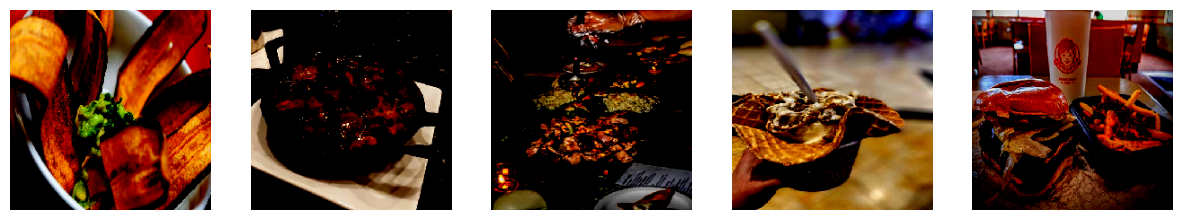

In [ ]:
# Plot the images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(class_images[i, :, :, :])  # Display RGB images
    axs[i].axis('off')
plt.show()

In [ ]:
# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(512 * 14 * 14, activation="relu", input_dim=100))
    model.add(Reshape((14, 14, 512)))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, activation="tanh", padding="same"))  # Output 3 channels for RGB
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=(224, 224, 3), padding="same"))  # Input shape for RGB
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
# Compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator()
z = tf.keras.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 100352)              │      10,135,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 56, 56, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 112, 112, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 224, 224, 3)         │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,891,587 (49.18 MB)

 Trainable params: 12,891,587 (49.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         200,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 859,585 (3.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 859,585 (3.28 MB)

In [ ]:
combined.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │      12,891,587 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │         859,585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,751,172 (52.46 MB)

 Trainable params: 12,891,587 (49.18 MB)

 Non-trainable params: 859,585 (3.28 MB)

In [ ]:
# Function to generate and plot images
def generate_and_plot_images(generator, num_images=5):
    # Generate noise and use the generator to create images
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)

    # Rescale images 0 - 1
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axs[i].imshow(generated_images[i, :, :, :])  # Display RGB images
        axs[i].axis('off')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
0 [D loss: 0.6547226309776306] [G loss: [array(0.6675807, dtype=float32), array(0.6675807, dtype=float32), array(0.4765625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


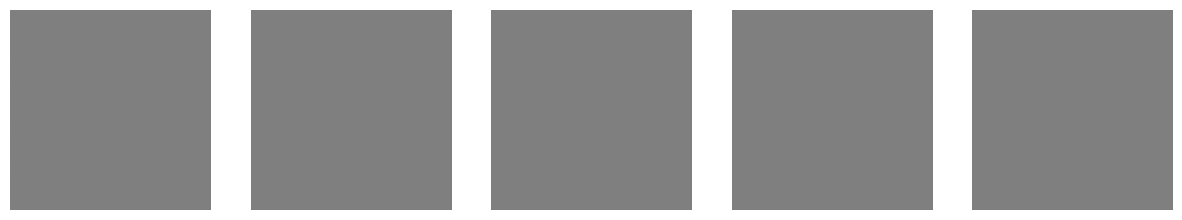

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

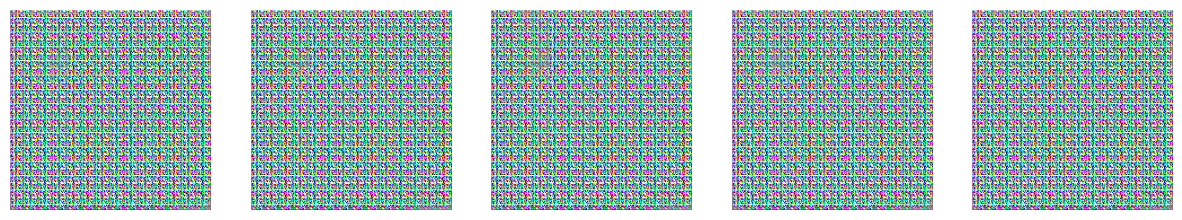

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

In [ ]:
# Training parameters
epochs = 100
batch_size = 64
save_interval = 50

# Training loop
for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, class_images.shape[0], batch_size)
    real_imgs = class_images[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print the progress
    if epoch % save_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")
        generate_and_plot_images(generator, num_images=5)

In [ ]:
generator.save('/content/drive/MyDrive/sem3_DL/deployment/DCGAN_generator_food.h5')
discriminator.save('/content/drive/MyDrive/sem3_DL/deployment/DCGAN_discriminator_food.h5')
combined.save('/content/drive/MyDrive/sem3_DL/deployment/DCGAN_combined_food.h5')